In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t
import moyra as ma
me.mechanics_printing()

In [2]:
Bodies = 2
DoFs = [5,7]

# heave and fold angle as degrres of freedom
p = ma.DynamicModelParameters(sum(DoFs))
p.DoFs  = ma.ModelSymbol(value = sum(DoFs),string = 'DoFs')
#gravity vector
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v') # The stationary point

In [3]:
# inner wing properites
p.rho_b = ma.ModelSymbol(value = 0.3,string = 'rho_b')
p.c_b = ma.ModelSymbol(value = 0.3,string = 'c_b')
p.L = ma.ModelSymbol(value = 0.3,string = 'L')
p.c = ma.ModelSymbol(value = 0.3,string = 'c')
p.x_f = ma.ModelSymbol(value = 0.3,string = 'x_f')
p.x_h = ma.ModelSymbol(value = 0.3,string = 'x_h')
p.EI = ma.ModelSymbol(value = 0.3,string = 'EI')
p.GJ = ma.ModelSymbol(value = 0.3,string = 'GJ')

p.y_0,p.x_0 = sym.symbols('y_0,x_0')

In [4]:
# fwt properties
## pendulum mass
p.m_f = ma.ModelSymbol(value = 0.3,string = 'm_f')
p.I_xx = ma.ModelSymbol(value = 0.3,string = 'I_xx')
p.I_yy = ma.ModelSymbol(value = 0.3,string = 'I_yy')
p.I_zz = ma.ModelSymbol(value = 0.3,string = 'I_zz')
p.I_xy = ma.ModelSymbol(value = 0.3,string = 'I_xy')
p.I_xz = ma.ModelSymbol(value = 0.3,string = 'I_xz')
p.I_yz = ma.ModelSymbol(value = 0.3,string = 'I_yz')

# pendulum length
p.L_f = ma.ModelSymbol(value = 0.3,string = 'L_f')
p.x_c = ma.ModelSymbol(value = 0.3,string = 'x_c')
p.y_c = ma.ModelSymbol(value = 0.3,string = 'y_c')

p.Lambda = ma.ModelSymbol(value = 0.3,string = 'Lambda')

In [5]:
## GET INNER WING ELEMENT
# get shape function
q_f = p.q[:DoFs[0]]
S,tau = ma.elements.FlexiElement.ShapeFunctions_OBM_IBN_TO(3,0,2,q_f,p.y_0,p.x_0,0,1,type='taylor')
u = S*sym.Matrix(q_f) + sym.Matrix([p.x_0,p.y_0,0])
# get reference frame
# inner_wing_frame = ma.frames.HomogenousFrame().Translate(p.q[0],0,p.q[1]).R_y(p.alpha_r).Translate(*u)
inner_wing_frame = ma.frames.HomogenousFrame().Translate(*u)
# get flexible element
link2_x__int = (p.x_0,p.x_f-p.c_b*sym.Rational(1,2),p.x_f+p.c_b*sym.Rational(1,2))
link2_y_int = (p.y_0,0,p.L)
main_wing_ele = ma.elements.FlexiElement(p.q,inner_wing_frame,p.rho_b,S,link2_x__int,link2_y_int,0,q_f,p.EI,p.GJ,grav_vec = p.g*p.g_v)

In [6]:
## GET FWT ELEMENT
fwt_frame= ma.frames.ReferenceFrame.EulerParameters(sym.Matrix(p.q[DoFs[0]:DoFs[0]+3]),sym.Matrix(p.q[DoFs[0]+3:DoFs[0]+7]))
#Create Elemnts
M = ma.elements.MassMatrix(p.m_f,p.I_xx,p.I_yy,p.I_zz,p.I_xy,p.I_xz,p.I_yz)
fwt_ele = ma.elements.RigidElement(p.q,fwt_frame,M,grav_vec = p.g*p.g_v, com_pos=[p.x_c-p.x_h,p.y_c,0])

In [7]:
C = []
# Euler parameters constraint
ep = sym.Matrix(p.q[DoFs[0]+3:DoFs[0]+7])
ep_c = (ep.T*ep)[0]-1
C = [*C,ep_c]

# hinge constriant
point = inner_wing_frame.transform_point([0]*3).subs({p.x_0:p.x_h,p.y_0:p.L}) - fwt_frame.transform_point([0,0,0])
C = [*C,*point]
# zdh = fwt_frame.transform_vector([sym.cos(p.Lambda),-sym.sin(p.Lambda),0]).T*inner_wing_frame.R_y()

inner_point = inner_wing_frame.transform_point([0]*3)
inner_hinge_vec = inner_point.subs({p.x_0:0,p.y_0:p.L-sym.tan(p.Lambda)*p.x_h}) - inner_point.subs({p.x_0:p.x_h,p.y_0:p.L})
inner_hinge_vec2 = sym.simplify(inner_hinge_vec)

C.append(*inner_hinge_vec.T*fwt_frame.transform_vector([0,0,1]))

C.append(*inner_hinge_vec.T*fwt_frame.transform_vector([-sym.sin(p.Lambda),sym.cos(p.Lambda),1]))

C = sym.Matrix(C)

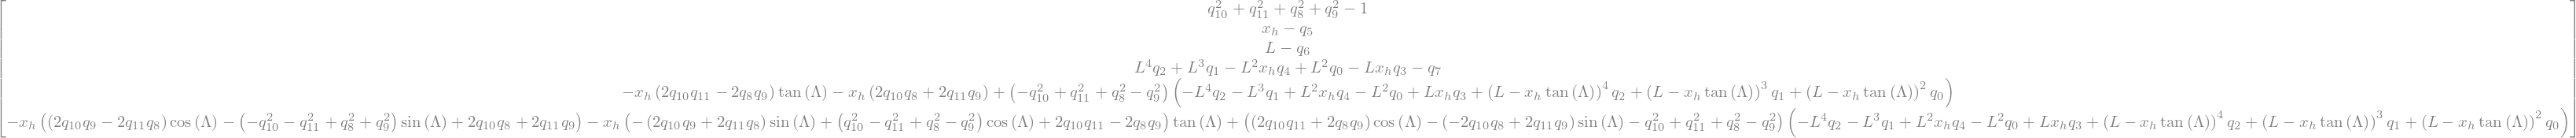

In [8]:
C

In [9]:
sm = ma.SymbolicModel.FromElementsAndForces(p.q,[main_wing_ele,fwt_ele],C=C)

Generating EoM for Element 1 out of 2 - default:FlexiElement
Generating EoM for Element 2 out of 2 - default:RigidElement


In [10]:
# create additional functions
funcs = []
funcs.append(('get_pos_inner_wing',inner_wing_frame.transform_point([0]*3)))
fwt_pos = [p.x_0,p.y_0,0]
funcs.append(('get_pos_fwt',fwt_frame.transform_point(fwt_pos)))

In [11]:
surf = inner_wing_frame.transform_point([0]*3)
v = ma.Wedge(surf.diff(p.x_0))*surf.diff(p.y_0)
hinge_normal = sym.simplify(v.subs({p.x_0:p.x_h,p.y_0:p.L}))
fwt_normal = fwt_frame.transform_vector([0,0,1])
fwt_hinge_vector = fwt_frame.transform_vector([sym.cos(p.Lambda),sym.sin(p.Lambda),0])
fold = -sym.atan2(hinge_normal.cross(fwt_normal).dot(fwt_hinge_vector),hinge_normal.dot(fwt_normal))
fold_dt = fold.diff(t)
funcs.append(('get_fold',fold))
funcs.append(('get_fold_dt',fold_dt))
funcs.append(('get_hinge_normal',hinge_normal))
funcs.append(('get_fwt_normal',fwt_normal))
funcs.append(('get_fwt_hinge_vector',fwt_hinge_vector))

In [12]:
#create function for an arbitary force of FWT
F_x,F_y,F_z,M_y = sym.symbols('F_x,F_y,F_z,M_y')
W = sym.Matrix([F_x,0,F_z,0,M_y,0])
fwt_Q_tmp = fwt_ele.frame.BodyJacobian(p.q,sym.Matrix(fwt_pos)).T*W
idx = [i for i, e in enumerate(p.q) if e in fwt_ele.q]
fwt_Q = sym.zeros(len(p.q),1)
for i,m_i in enumerate(idx):
    fwt_Q[m_i] += fwt_Q_tmp[i]
funcs.append(('get_fwt_Q',fwt_Q))

In [13]:
#create function for an arbitary force of Main Wing
F_x,F_y,F_z,M_y = sym.symbols('F_x,F_y,F_z,M_y')
W = sym.Matrix([F_x,0,F_z,0,0,0])
W_m = sym.Matrix([0,0,0,0,M_y,0])
main_Q = inner_wing_frame.BodyJacobian(p.q).T*W
main_Q += inner_wing_frame.R_y(tau).BodyJacobian(p.q).T*W_m
funcs.append(('get_main_Q',main_Q))

In [14]:
#create function for A of each frame
funcs.append(('get_fwt_A',fwt_ele.frame.A))
funcs.append(('get_main_A',inner_wing_frame.A))

In [15]:
#create function for Body Velocity on FWT and Main wing
funcs.append(('get_fwt_V_b',fwt_ele.frame.BodyVelocity(sym.Matrix(fwt_pos))))
# funcs.append(('get_fwt_V_b',fwt_ele.frame.transform_point([p.x_0,p.y_0,0]).diff(t)))
funcs.append(('get_main_V_b',inner_wing_frame.A.T*inner_wing_frame.R.diff(t)))

In [16]:
# create custom definition for octave printer (to cache results)
octave_user_functions = {}
# octave_user_functions["sin"] = "sin_cache"
# octave_user_functions["cos"] = "cos_cache"

In [17]:
%timeit -r 1 -n 1
base_dir = "C:\\Git\\NastranMBD\\"
class_name = "Flexi_wing_MBD_EP"
base_class = "mBaseMBD"
sm.to_matlab_class(p,base_dir,class_name,base_class, additional_funcs=funcs, octave_user_functions=octave_user_functions)

Unknown variable x_0 found in function get_pos_inner_wing. It will be added to the function signature.
Unknown variable y_0 found in function get_pos_inner_wing. It will be added to the function signature.
Unknown variable x_0 found in function get_pos_fwt. It will be added to the function signature.
Unknown variable y_0 found in function get_pos_fwt. It will be added to the function signature.
Unknown variable F_z found in function get_fwt_Q. It will be added to the function signature.
Unknown variable M_y found in function get_fwt_Q. It will be added to the function signature.
Unknown variable F_x found in function get_fwt_Q. It will be added to the function signature.
Unknown variable x_0 found in function get_fwt_Q. It will be added to the function signature.
Unknown variable y_0 found in function get_fwt_Q. It will be added to the function signature.
Unknown variable F_z found in function get_main_Q. It will be added to the function signature.
Unknown variable x_0 found in functio